# Co-rotating vortices

In [1]:
using ViscousFlow

┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1242


In [2]:
using Plots
pyplot()
default(grid = false)

### Set up a grid and a Reynolds number

In [42]:
Re = 200
xlim = (-2,2); ylim = (-2,2)
Δx, Δt = setstepsizes(Re,gridRe=4)

(0.02, 0.01)

In [43]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt)

Navier-Stokes system on a grid of size 208 x 208

In [44]:
w₀ = Nodes(Dual,size(sys))
xg,yg = coordinates(w₀,dx=cellsize(sys),I0=origin(sys))
nothing

### Create initial conditions

In [45]:
x01 = (-0.5,0); x02 = (0.5,0); σ = 0.2; Γ = 1

twovortex = SpatialGaussian(σ,x01...,Γ) + SpatialGaussian(σ,x02...,Γ)
patchfield = GeneratedField(w₀,twopatch,sys.grid);

### Set up the integrator

#### First set up the integrating factor plan and right-hand side function

In [46]:
plan_intfact(t,w) = CartesianGrids.plan_intfact(t,w,sys)
r₁(w,t) = ConstrainedSystems.r₁(w,t,sys)

r₁ (generic function with 1 method)

#### And finally, the integrator

In [47]:
solver = IFRK(w₀,timestep(sys),plan_intfact,r₁,rk=ConstrainedSystems.RK31)

Order-3 IF-RK integator with
   State of type Nodes{Dual,208,208,Float64,Array{Float64,2}}
   Time step size 0.01


### Now solve the problem

In [48]:
# Initialize the fields
t = 0.0
w = Δx*patchfield();

# Rate at which to store field data
tsample = 1.0

# Field data storage plan
S = StorePlan(tsample,"state"=>w,"time"=>t)
data_history = initialize_storage(S);

store_data!(data_history,t,S,"state" => w, "time" => t);

In [49]:
tf = 5
@time for ti in timerange(tf,sys)
    global t, w = solver(t,w)
    
    store_data!(data_history,t,S,"state" => w, "time" => t)
end

 12.298754 seconds (494.57 k allocations: 6.936 GiB, 6.97% gc time)


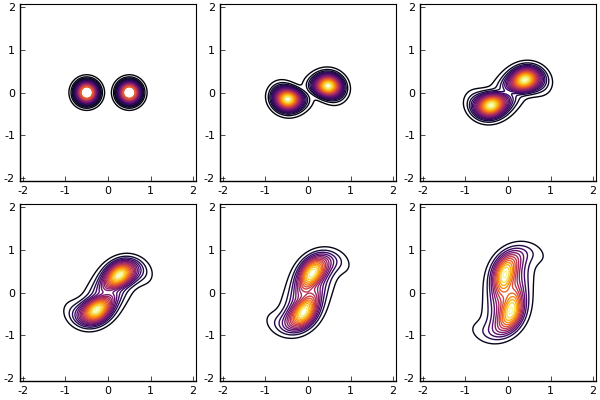

In [50]:
plt = plot(layout = (2,3), size = (600, 400), legend=:false)
for i in 1:6
    plot!(plt[i],xg,yg,vorticity(data_history["state"][i],sys),levels=range(0.1,5,length=31))
end
plt